In [1]:
# =======================
# COMMON FUNCTIONS
# =======================
import numpy as np
import tarfile

def loadTGZ(tgz, fPath, dtype, skip_header=False):
    """
    Load a CSV file from the tarfile 'tgz' given its file path 'fPath'.  
    Optionally skip the header row (if skip_header=True). 
    Reshape the data into 256*256 and cast to the specified dtype.
    """
    with tgz.extractfile(fPath) as csvfile:
        data = np.genfromtxt(csvfile, delimiter=",", skip_header=1 if skip_header else 0)
        if data.size != 256*256:
            raise ValueError(f"Data size mismatch in {fPath}: expected {256*256}, got {data.size}")
        return data.reshape(256*256).astype(dtype)

def removeMaskNaN(outSet):
    """Remove entries with NaN in any file and entries with mask != 0."""
    aMask = (outSet["mask"] == 0)
    for k in outSet.keys():
        aMask &= ~np.isnan(outSet[k])
    for k in outSet.keys():
        outSet[k] = outSet[k][aMask]
    return outSet

def normSet(outSet):
    """
    Normalize the variables in a consistent way (using a sensor-specific offset)
    to allow comparisons between sensors.
    """
    offset = np.mean(outSet["tMean0"]).astype(np.float16)
    outSet["tMean0"] = (outSet["tMean0"] - offset) / 75.
    outSet["tMeanF"] = (outSet["tMeanF"] - (offset + 150)) / 75.
    outSet["tWidth0"] = (outSet["tWidth0"] - 10) / 7.5
    outSet["tWidthF"] = (outSet["tWidthF"] - 10) / 7.5
    return outSet

# =======================
# CELL 1: OLD DATA LOADING
# =======================
tgzFileName = "ASideFirstModules.tgz"

# Define module training list for old data
moduleFiles = [
    "equalisation_M98_A1",
    "equalisation_M94_A2",
    "equalisation_M96_A3",
    "equalisation_M59_A4",
    "equalisation_N22_A5",
    "equalisation_M116_A6",
    "equalisation_N030_A7",
    "equalisation_M90_A8",
    "equalisation_N029_A9",
    "equalisation_N013_A10"
]

# Define training set (to be excluded from evaluation)
trainingSet = [
    ("equalisation_N030_A7","VP0-1"), #offset = 2
    ("equalisation_M59_A4","VP0-0"), #offset = 1
    ("equalisation_M98_A1","VP0-1"), #offset = 0
    ("equalisation_N030_A7","VP3-2"), #offset = -1
    ("equalisation_M98_A1","VP2-0") #offset = -2
]

vpList = [f"VP{i}-{j}" for i in range(4) for j in range(3)]
evaluationSet = [(f, vp) for f in moduleFiles for vp in vpList]
evaluationSet = [s for s in evaluationSet if s not in trainingSet]

print(f"Old Data:\n Training set: {trainingSet}\n {len(evaluationSet)} evaluation sets to test.")
print("First:", evaluationSet[0], "Last:", evaluationSet[-1])

def extractFromTGZ(tgzName, dSet):
    """
    Extract the old data files for a given dataset dSet.
    dSet is a tuple: (module_name, vp), e.g. ("equalisation_M98_A1", "VP0-1").
    """
    path = dSet[0] + "/"
    outSet = {}
    with tarfile.open(tgzName, 'r:gz') as tgz:
        outSet["tMean0"] = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Trim0_Noise_Mean.csv", np.float16)
        outSet["tMeanF"] = loadTGZ(tgz, path + f"Module0_{dSet[1]}_TrimF_Noise_Mean.csv", np.float16)
        outSet["tWidth0"] = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Trim0_Noise_Width.csv", np.float16)
        outSet["tWidthF"] = loadTGZ(tgz, path + f"Module0_{dSet[1]}_TrimF_Noise_Width.csv", np.float16)
        outSet["mask"]    = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Matrix_Mask.csv", np.float16)
        outSet["trim"]    = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Matrix_Trim.csv", np.int8)
    return removeMaskNaN(outSet)


Old Data:
 Training set: [('equalisation_N030_A7', 'VP0-1'), ('equalisation_M59_A4', 'VP0-0'), ('equalisation_M98_A1', 'VP0-1'), ('equalisation_N030_A7', 'VP3-2'), ('equalisation_M98_A1', 'VP2-0')]
 115 evaluation sets to test.
First: ('equalisation_M98_A1', 'VP0-0') Last: ('equalisation_N013_A10', 'VP3-2')


In [2]:
# =======================
# CELL 2: NEW OPERATIONAL DATA LOADING
# =======================
tgzFileName_new = "Module25_20230621_trim.tgz"

# For the new data, the module prefix is fixed as "Module25".
evaluationSet_new = [("Module25", vp) for vp in vpList]

print(f"\nNew Operational Data:\n {len(evaluationSet_new)} evaluation sets to test.")
print("First:", evaluationSet_new[0], "Last:", evaluationSet_new[-1])

def extractFromTGZ_new(tgzName, dSet) :
    """
    Extract the new operational data files for a given dataset dSet.
    dSet is a tuple: (module_prefix, vp), e.g. ("Module25", "VP0-0").
    For noise files, we skip the header row; for matrix files, we do not.
    """
    module_prefix, vp = dSet
    outSet = {}
    with tarfile.open(tgzName, 'r:gz') as tgz:
        # Noise files (skip header)
        outSet["tMean0"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Trim0_Noise_Mean_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tMeanF"] = loadTGZ(tgz, f"{module_prefix}_{vp}_TrimF_Noise_Mean_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tWidth0"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Trim0_Noise_Width_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tWidthF"] = loadTGZ(tgz, f"{module_prefix}_{vp}_TrimF_Noise_Width_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        # Matrix files (do not skip header)
        outSet["mask"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Matrix_Mask_2023-06-21_14-06-30.csv", np.float16, skip_header=False)
        outSet["trim"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Matrix_Trim_2023-06-21_14-06-30.csv", np.int8, skip_header=False)
    return removeMaskNaN(outSet)


New Operational Data:
 12 evaluation sets to test.
First: ('Module25', 'VP0-0') Last: ('Module25', 'VP3-2')


In [3]:
from matplotlib import pyplot as plt

# Now plot the data to see what we have as a training set

def plotCorr(ax,trim,val,ytitle):
    xBins = np.arange(-0.5,15.5,1)
    yBins = np.linspace(np.min(val),np.max(val),100)
    ax.hist2d(trim,val,bins=[xBins,yBins])
    ax.set_xlabel('Final Trim')
    ax.set_ylabel(ytitle)

def drawSet(dSet, title='Dataset', norm=False):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(14,3))
    fig.suptitle(title)
    # final Trim
    ax1.hist(dSet["trim"],bins=np.arange(-0.5,15.5))
    ax1.set_xlabel('Final Trim')
    # mean0 & F
    if norm :
        bins = np.linspace(-2,2,128)
    else :
        bins = np.linspace(-0.5,2047.5,128)
    ax2.hist(dSet["tMean0"], bins=bins, label = "0 Mean")
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_xlabel('Mean 0')
    ax3.hist(dSet["tMeanF"], bins=bins, label = "F Mean")
    ax3.legend()
    ax3.set_yscale('log')
    ax3.set_xlabel('Mean F')
    # widths
    if norm :
        bins = np.linspace(-2,2,128)
    else :
        bins = np.linspace(-0.5,25.5, 26)
    ax4.hist(dSet["tWidth0"], bins=bins, label = "0 Width")
    ax4.legend()
    ax4.set_yscale('log')
    ax4.set_xlabel('Width 0')
    ax5.hist(dSet["tWidthF"], bins=bins, label = "F Width")
    ax5.legend()
    ax5.set_yscale('log')
    ax5.set_xlabel('Width F')
    plt.tight_layout()
    plt.show()
    # now correlations
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(12,3))
    plotCorr(ax0,dSet["trim"],dSet["tMean0"],'Mean 0')
    plotCorr(ax1,dSet["trim"],dSet["tMeanF"],'Mean F')
    plotCorr(ax2,dSet["trim"],dSet["tWidth0"],'Width 0')
    plotCorr(ax3,dSet["trim"],dSet["tWidthF"],'Width F')
    plt.tight_layout()
    plt.show()

def drawSetwMask(dSet, title='Dataset', norm=False):
    # Create a figure with 6 subplots in one row
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(17, 3))
    fig.suptitle(title)
    
    # Plot for mask distribution
    ax1.hist(dSet["mask"], bins=50, color='gray')
    ax1.set_xlabel("Mask")
    ax1.set_ylabel("Frequency")
    
    # Histogram for final Trim
    ax2.hist(dSet["trim"], bins=np.arange(-0.5, 15.5, 1), color='C0')
    ax2.set_xlabel('Final Trim')
    
    # Plot for tMean0
    if norm:
        bins = np.linspace(-2, 2, 128)
    else:
        bins = np.linspace(-0.5, 2047.5, 128)
    ax3.hist(dSet["tMean0"], bins=bins, label="0 Mean", color='C1')
    ax3.legend()
    ax3.set_yscale('log')
    ax3.set_xlabel('Mean 0')
    
    # Plot for tMeanF
    ax4.hist(dSet["tMeanF"], bins=bins, label="F Mean", color='C2')
    ax4.legend()
    ax4.set_yscale('log')
    ax4.set_xlabel('Mean F')
    
    # For widths, adjust bins based on normalization flag
    if norm:
        bins = np.linspace(-2, 2, 128)
    else:
        bins = np.linspace(-0.5, 25.5, 26)
    ax5.hist(dSet["tWidth0"], bins=bins, label="0 Width", color='C3')
    ax5.legend()
    ax5.set_yscale('log')
    ax5.set_xlabel('Width 0')
    
    ax6.hist(dSet["tWidthF"], bins=bins, label="F Width", color='C4')
    ax6.legend()
    ax6.set_yscale('log')
    ax6.set_xlabel('Width F')
    
    plt.tight_layout()
    plt.show()
    
    # Now the correlation plots (2D histograms) for each feature vs. trim
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(12, 3))
    plotCorr(ax0, dSet["trim"], dSet["tMean0"], 'Mean 0')
    plotCorr(ax1, dSet["trim"], dSet["tMeanF"], 'Mean F')
    plotCorr(ax2, dSet["trim"], dSet["tWidth0"], 'Width 0')
    plotCorr(ax3, dSet["trim"], dSet["tWidthF"], 'Width F')
    plt.tight_layout()
    plt.show()

Loaded and normalized training data for: ('equalisation_N030_A7', 'VP0-1')
Loaded and normalized training data for: ('equalisation_M59_A4', 'VP0-0')
Loaded and normalized training data for: ('equalisation_M98_A1', 'VP0-1')
Loaded and normalized training data for: ('equalisation_N030_A7', 'VP3-2')
Loaded and normalized training data for: ('equalisation_M98_A1', 'VP2-0')
Initial MSE=82.9346, MAE=8.7728
Epoch 1/10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - loss: 79.0720 - mae: 8.5442
Epoch 2/10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 66.6930 - mae: 7.7836
Epoch 3/10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 58.3238 - mae: 7.2215
Epoch 4/10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 50.2419 - mae: 6.6387
Epoch 5/10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 38.5892 - mae: 5.7082
Epoch 6/10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 25.1375 - mae: 4.4241
Epoch 7/10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 14.2570 - mae: 3.1328
E

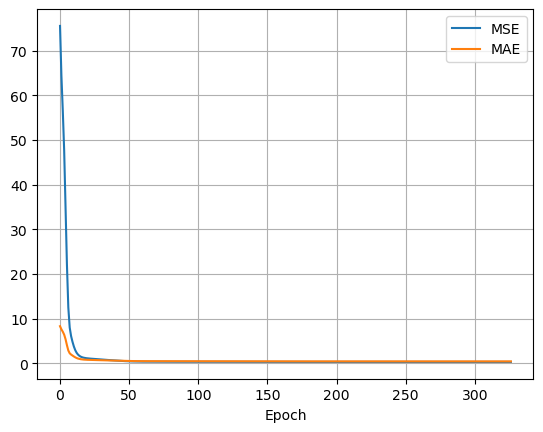

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model
from keras.callbacks import EarlyStopping
import time

trainSets = []
for dSet in trainingSet:
    try:
        outSet = extractFromTGZ(tgzFileName, dSet)
        outSet_norm = normSet(outSet)
        trainSets.append(outSet_norm)
        print("Loaded and normalized training data for:", dSet)
    except Exception as e:
        print("Error loading training data for", dSet, ":", e)

# Initialize a dictionary to store combined training data
combined_trainSet = {
    "tMean0": [],
    "tMeanF": [],
    "tWidth0": [],
    "tWidthF": [],
    "trim": []
}

# Merge all normalized datasets into one
for trainSet in trainSets:
    for key in combined_trainSet.keys():
        combined_trainSet[key].extend(trainSet[key])  # Append each dataset

# Convert lists to NumPy arrays
for key in combined_trainSet.keys():
    combined_trainSet[key] = np.array(combined_trainSet[key])

def buildModel_regression(nVal, nLayer, nUnits):
    inputs = Input(shape=(nVal,))
    x = Dense(nUnits)(inputs)
    x = LeakyReLU(0.1)(x)
    for _ in range(nLayer - 1):
        x = Dense(nUnits)(x)
        x = LeakyReLU(0.1)(x)
    output = Dense(1)(x)
    model = Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mean_squared_error",
        metrics=["mae"]
    )
    return model

def trainNN_regression(dSet, nLayer, nUnits, saveFile=None):
    # extract features & target
    x_all = np.column_stack([
        dSet["tMean0"], dSet["tMeanF"],
        dSet["tWidth0"], dSet["tWidthF"]
    ])
    y_all = dSet["trim"].astype(float)

    # split even/odd for train/eval
    x_train, y_train = x_all[::2], y_all[::2]
    x_eval,  y_eval  = x_all[1::2], y_all[1::2]

    model = buildModel_regression(x_all.shape[1], nLayer, nUnits)

    # initial eval
    init = model.evaluate(x_eval, y_eval, verbose=0)
    print(f"Initial MSE={init[0]:.4f}, MAE={init[1]:.4f}")

    # train
    es = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        batch_size=2048,
        epochs=10000,
        callbacks=[es],
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    # final eval
    final = model.evaluate(x_eval, y_eval, verbose=0)
    print(f"Final   MSE={final[0]:.4f}, MAE={final[1]:.4f}")

    # plot loss & mae
    plt.plot(history.history["loss"], label="MSE")
    plt.plot(history.history["mae"],  label="MAE")
    plt.xlabel("Epoch"); plt.legend(); plt.grid()
    plt.show()

    if saveFile:
        model.save(saveFile, overwrite=True)
    return model

# --- run it on your combined_trainSet dict ---
saveFile = f"NN_{trainingSet[0][0]}_{trainingSet[0][1]}_regression.keras"
model = trainNN_regression(combined_trainSet, nLayer=2, nUnits=4, saveFile=saveFile)


In [28]:
import numpy as np
import csv
from keras.models import load_model

def load_and_prep(dSet, extractor, normalise=True):
    out = extractor(tgzFileName, dSet)
    out = removeMaskNaN(out)
    if normalise:
        out = normSet(out)
    x = np.column_stack([
        out["tMean0"], out["tMeanF"],
        out["tWidth0"], out["tWidthF"]
    ])
    y = out["trim"].astype(int)
    return x, y

def adjacent_accuracy(y_true, y_pred_cont, tol=1):
    y_int = np.clip(np.round(y_pred_cont), 0, 15).astype(int)
    return np.mean(np.abs(y_int - y_true) <= tol)

# load your saved regression model
reg = load_model(saveFile, compile=False)

import random

random_eval_sets = random.sample(evaluationSet, 30)

results = []
for dSet in random_eval_sets:
    x_eval, y_eval = load_and_prep(dSet, extractFromTGZ, normalise=True)
    y_pred = reg.predict(x_eval).flatten()
    acc = adjacent_accuracy(y_eval, y_pred, tol=1)
    results.append({
        "Dataset": f"{dSet[0]}-{dSet[1]}",
        "AdjAcc_reg": f"{acc:.4f}",
        "Batch Size": "2048"
    })

import os
import csv

csv_file = "regression_adjacc_results_tune.csv"
fieldnames = ["Dataset","AdjAcc_reg","Batch Size"]

# detect whether we need to write the header
write_header = not os.path.exists(csv_file)

with open(csv_file, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if write_header:
        writer.writeheader()
    writer.writerows(results)

print(f"Saved regression ±1 adjacent accuracies to '{csv_file}'")


2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step
2046/2046 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step
2043/2043 

In [ ]:
import os, csv

results_new = []
for dSet in evaluationSet_new:
    # 1) Pull & clean with the new tar
    out = extractFromTGZ_new(tgzFileName_new, dSet)
    out = removeMaskNaN(out)
    out = normSet(out)

    # 2) Build x, y
    x_eval = np.column_stack([out["tMean0"], out["tMeanF"],
                              out["tWidth0"], out["tWidthF"]])
    y_eval = out["trim"].astype(int)

    # 3) Predict & score
    y_pred = reg.predict(x_eval, batch_size=2048).flatten()
    acc    = adjacent_accuracy(y_eval, y_pred, tol=1)

    results_new.append({
        "Dataset":    f"{dSet[0]}-{dSet[1]}",
        "AdjAcc_reg": f"{acc:.4f}",
    })

# 4) Append to the same CSV
csv_file   = "regression_adjacc_results.csv"
fieldnames = ["Dataset","AdjAcc_reg","Batch Size"]
write_hdr  = not os.path.exists(csv_file)

with open(csv_file, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if write_hdr:
        writer.writeheader()
    writer.writerows(results_new)

print(f"Appended {len(results_new)} Module25 results to '{csv_file}'")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
Appended 12 Module25 results to 'regression_adjacc_results.csv'
